In [1]:
#from mpi4py import MPI 
import netket as nk
import netket.experimental as nkx
import nqs.BeH2_ptutorial as bpm
import pickle
import numpy as np
import math
from functools import reduce
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# get data to build the qubit Hamiltonian for BeH2
pauli_list   = np.load('../data/tomography/BeH2/paulis.file',allow_pickle=True)
interactions = np.load('../data/tomography/BeH2/interactions.file',allow_pickle = True)
for k in range(10):
    print('Pauli:',pauli_list[k],' | Interaction: %.3E' % interactions[k])
print('...')

Pauli: IIIIII  | Interaction: -1.707E+01
Pauli: ZIIIII  | Interaction: 1.156E-01
Pauli: XXZIII  | Interaction: 7.270E-03
Pauli: YYIIII  | Interaction: 7.270E-03
Pauli: ZZIIII  | Interaction: 1.000E-01
Pauli: ZXXIII  | Interaction: -4.618E-03
Pauli: IYYIII  | Interaction: -4.618E-03
Pauli: IZZIII  | Interaction: -1.599E-01
Pauli: IIZIII  | Interaction: -3.908E-01
Pauli: IIIZII  | Interaction: 1.156E-01
...


In [3]:
# Define some parameters + get paths to data

N = 6          # Number of qubits
ns = 100000    # Number of training samples
lr = 0.005      # Learning rate
M = 20000      # Number of samples for the negative CD phase
bs = 100     # Batch size
epochs = 300   # Epochs


samples_path = "../data/tomography/BeH2/train_samples.txt"
bases_path = "../data/tomography/BeH2/train_bases.txt"
pauli_path = "../data/tomography/BeH2/paulis.file"
interactions_path = "../data/tomography/BeH2/interactions.file"
ed_energy = float(np.loadtxt("../data/tomography/BeH2/energy.txt"))
psi0 = np.loadtxt("../data/tomography/BeH2/psi.txt")

In [4]:
psi0

array([-5.81061279e-16,  1.55898334e-17,  2.60173055e-16, -6.34340264e-17,
       -5.27084735e-18, -4.22405947e-16, -4.39571078e-16, -8.53024890e-17,
       -1.40233185e-16,  8.71311245e-03,  1.62174211e-03,  1.40012954e-16,
       -5.64321033e-03,  2.63953129e-16, -4.61694423e-16,  1.87897356e-03,
        7.95891039e-17,  1.62174211e-03, -6.18030936e-02,  5.94663742e-16,
       -2.66801733e-03,  3.70688077e-16,  3.53824630e-16,  4.75449726e-02,
       -5.72155797e-17, -2.49914646e-16, -2.36595855e-16, -2.79809215e-02,
        1.89599335e-15, -5.12492398e-16,  4.19017623e-02, -1.15696469e-16,
       -8.71589307e-16, -5.64321033e-03, -2.66801733e-03, -2.19399394e-15,
        9.89989331e-01,  1.09026373e-16,  5.41641412e-15, -3.19908661e-03,
        3.40740278e-16, -4.22707697e-16,  1.22337899e-16, -1.58246406e-16,
       -2.27298586e-16, -8.60540447e-18, -2.66637460e-16, -4.44007642e-16,
        7.02191571e-17,  3.04821532e-16,  4.35256206e-16,  4.19017623e-02,
       -4.88407380e-15,  

In [5]:
psi0.shape

(64,)

In [6]:
# build rbm + sampler + driver etc -- start with Hamiltonian first

# Hilbert space
hi = nk.hilbert.Qubit(N=6)
# NetKet Hamiltonian
hamiltonian = bpm.BuildHamiltonian(N,hi,pauli_path,interactions_path)

In [7]:
# Check Hamiltonian after building it
# Get the Hamiltonian as a dense matrix
H_matrix = hamiltonian.to_dense()

print("\n=== HAMILTONIAN ANALYSIS ===")
print(f"Hamiltonian type: {type(hamiltonian)}")
print(f"Hamiltonian dtype: {hamiltonian.dtype}")
print(f"Hamiltonian shape: {H_matrix.shape}")
print(f"Is Hermitian? {np.allclose(H_matrix, H_matrix.conj().T)}")

# Get eigenvalues + eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)
print(f"\nLowest 5 eigenvalues:")
print(eigenvalues[:5])
print(f"Highest 5 eigenvalues:")
print(eigenvalues[-5:])

print(f"\nED ground state energy: {ed_energy}")
print(f"Hamiltonian ground state: {eigenvalues[0]}")

ground_state = eigenvectors[:, 0]
print(f"\nGround state eigenvector shape: {ground_state.shape}")

# get exact ground state and compare with the one they got:
print("Overlap between the gs calculated here and the one they got:",np.dot(ground_state,psi0))

# Try to compute energy on a random state
test_state = np.random.randn(2**N) + 1j * np.random.randn(2**N)
test_state = test_state / np.linalg.norm(test_state)

# Manual energy calculation
H_matrix = hamiltonian.to_dense()  # Get full matrix
test_energy = np.vdot(test_state, H_matrix @ test_state).real
print(f"Test energy on random state: {test_energy}")


=== HAMILTONIAN ANALYSIS ===
Hamiltonian type: <class 'netket.operator._local_operator.jax.LocalOperatorJax'>
Hamiltonian dtype: complex128
Hamiltonian shape: (64, 64)
Is Hermitian? True

Lowest 5 eigenvalues:
[-19.03879505 -18.57708276 -18.53549258 -18.38773058 -18.38068849]
Highest 5 eigenvalues:
[-15.90826383 -15.64704217 -15.64704217 -15.06263444 -13.72257779]

ED ground state energy: -19.038795049423
Hamiltonian ground state: -19.038795049422998

Ground state eigenvector shape: (64,)
Overlap between the gs calculated here and the one they got: (1.0000000000000007+0j)
Test energy on random state: -16.924146185970933


In [32]:
# confirming that psi0 is indeed the ground state
np.vdot(psi0, H_matrix @ psi0).real / np.vdot(psi0, psi0).real

np.float64(-19.038795049422998)

In [19]:
# train rbm

# Load training data -- OLD DATA:: this dataset has something off -- don't know yet exactly:: could be incomplete or mismatched
rotations, tr_samples, tr_bases = bpm.LoadData(N,hi,samples_path, bases_path)
if (ns > tr_samples.shape[0]):
    "Not enough training samples"
else:
    training_samples = tr_samples[0:ns]
    training_bases   = tr_bases[0:ns]
    
# load bases using new function:
Us = bpm.load_bases(bases_path)

Loaded 128000 measurement bases from ../data/tomography/BeH2/train_bases.txt
Number of qubits: 6
Unique bases: 54



### FIX #2 New complete dataset:

There was something wrong with the data we got from the old repository or the way it was being loaded by the driver. So I generated similar data by iterating through these steps n_samples times (the size of the dataset):
- Randomly sample a base string/Pauli Word (e.g ZIYZIX) from the pauli strings that make up the Beh2 qubit hamiltonian to make a set of 12
- Apply corresponding rotations to the qubits. 
- Sample a bitstring from the rotated state

### NB:
Like they did in the original notebook, before sampling the Pauli Words, I replaced all I's with Z's in the base-strings/Pauli Words of the qubit Hamiltonian. This is because 'I' in a base-string would mean that we don't measure that qubit but we do in fact get an outcome for all qubit positions. And since all measurements are made in the Z basis, and for I no rotation is applied on the qubit, it makes sense to swap Is for Zs. 


In [8]:
# LOAD GEN DATA

data_file = '../Scripts/beh2_measurements_M128000new.npz'
data = np.load(data_file, allow_pickle=True)

# Extract components
bitstrings = data['bitstrings']           # Shape: (n_samples, n_qubits)
basis_strings = data['basis_strings']     # Shape: (n_samples,) - strings like 'XZYZZI'
basis_operators = data['basis_operators'] # NetKet LocalOperator objects
ground_state = data['ground_state']       # Exact ground state vector
statistics = data['statistics'].item()    # Dictionary with dataset stats
pauli_strings = data['pauli_strings']     # Original Hamiltonian Pauli terms
coefficients = data['coefficients']       # Hamiltonian coefficients
n_qubits = data['n_qubits'].item()        # Number of qubits (6 for BeH2)

# Print summary
print(f"Loaded BeH2 measurement dataset:")
print(f"  Number of qubits: {n_qubits}")
print(f"  Total measurements: {len(bitstrings):,}")
print(f"  Unique bases: {statistics['unique_bases']}")
print(f"  Unique bitstrings: {statistics['unique_bitstrings']}")
print(f"\nBitstrings shape: {bitstrings.shape}")
print(f"Basis strings shape: {basis_strings.shape}")
print(f"\nExample measurement:")
print(f"  Bitstring: {bitstrings[0]}")
print(f"  Basis: {basis_strings[0]}")


Loaded BeH2 measurement dataset:
  Number of qubits: 6
  Total measurements: 128,000
  Unique bases: 54
  Unique bitstrings: 64

Bitstrings shape: (128000, 6)
Basis strings shape: (128000,)

Example measurement:
  Bitstring: [1. 1. 1. 1. 0. 0.]
  Basis: ZYYZZZ


In [10]:
bitstrings[0]

array([1., 1., 1., 1., 0., 0.])

In [9]:
# peak and see how they look
basis_operators[:3]

array([LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0j, dtype=complex128),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0j, dtype=complex128),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0j, dtype=complex128)],
      dtype=object)

In [11]:
len(rotations)

54

In [12]:
print(np.unique(Us,return_counts=True))
print(np.unique(Us,return_counts=True)[0].shape)

(array(['XXXXXX', 'XXXXZZ', 'XXXYXY', 'XXXZXZ', 'XXXZZX', 'XXZXXZ',
       'XXZYYZ', 'XXZZXX', 'XXZZYY', 'XXZZZZ', 'XZXZZZ', 'XZZXXX',
       'XZZXZZ', 'XZZYXY', 'XZZZXZ', 'XZZZZX', 'YXYXXX', 'YXYXZZ',
       'YXYYXY', 'YXYZXZ', 'YXYZZX', 'YYZXXZ', 'YYZYYZ', 'YYZZXX',
       'YYZZYY', 'YYZZZZ', 'YZYZZZ', 'ZXXXXZ', 'ZXXYYZ', 'ZXXZXX',
       'ZXXZYY', 'ZXXZZZ', 'ZXZXXX', 'ZXZXZZ', 'ZXZYXY', 'ZXZZXZ',
       'ZXZZZX', 'ZYYXXZ', 'ZYYYYZ', 'ZYYZXX', 'ZYYZYY', 'ZYYZZZ',
       'ZZXXXX', 'ZZXXZZ', 'ZZXYXY', 'ZZXZXZ', 'ZZXZZX', 'ZZZXXZ',
       'ZZZXZX', 'ZZZYYZ', 'ZZZYZY', 'ZZZZXX', 'ZZZZYY', 'ZZZZZZ'],
      dtype='<U6'), array([  800,  1530,   774,  1533,  1547,   779,   761,   818,   791,
        4751,  1581,  1530,  3120,  1436,  3181,  3105,   789,  1568,
         770,  1520,  1529,   761,   716,   822,   768,  4671,   780,
         798,   809,   799,   756,  4552,  1505,  3101,  1576,  3032,
        3137,   816,   743,   783,   751,  4627,  1517,  3142,  1502,
        3081,  3093,  465

In [14]:
replaced_pauli_list = [pauli_word.replace('I','Z') for pauli_word in pauli_list]
print(np.unique(replaced_pauli_list,return_counts=True))
print(np.unique(replaced_pauli_list,return_counts=True)[0].shape)

(array(['XXXXXX', 'XXXXZZ', 'XXXYXY', 'XXXZXZ', 'XXXZZX', 'XXZXXZ',
       'XXZYYZ', 'XXZZXX', 'XXZZYY', 'XXZZZZ', 'XZXZZZ', 'XZZXXX',
       'XZZXZZ', 'XZZYXY', 'XZZZXZ', 'XZZZZX', 'YXYXXX', 'YXYXZZ',
       'YXYYXY', 'YXYZXZ', 'YXYZZX', 'YYZXXZ', 'YYZYYZ', 'YYZZXX',
       'YYZZYY', 'YYZZZZ', 'YZYZZZ', 'ZXXXXZ', 'ZXXYYZ', 'ZXXZXX',
       'ZXXZYY', 'ZXXZZZ', 'ZXZXXX', 'ZXZXZZ', 'ZXZYXY', 'ZXZZXZ',
       'ZXZZZX', 'ZYYXXZ', 'ZYYYYZ', 'ZYYZXX', 'ZYYZYY', 'ZYYZZZ',
       'ZZXXXX', 'ZZXXZZ', 'ZZXYXY', 'ZZXZXZ', 'ZZXZZX', 'ZZZXXZ',
       'ZZZXZX', 'ZZZYYZ', 'ZZZYZY', 'ZZZZXX', 'ZZZZYY', 'ZZZZZZ'],
      dtype='<U6'), array([ 1,  2,  1,  2,  2,  1,  1,  1,  1,  6,  2,  2,  4,  2,  4,  4,  1,
        2,  1,  2,  2,  1,  1,  1,  1,  6,  1,  1,  1,  1,  1,  6,  2,  4,
        2,  4,  4,  1,  1,  1,  1,  6,  2,  4,  2,  4,  4,  6,  2,  6,  1,
        6,  6, 31]))
(54,)


In [20]:
len(replaced_pauli_list)

165

In [21]:
# SO they DID replace all Is with Zs in their dataset
list1 = np.unique(replaced_pauli_list)
list2 = np.unique(Us)
print(list1==list2)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


In [26]:
np.log2(512)

np.float64(9.0)

In [22]:
list1.shape

(54,)

In [15]:
U_operators = bpm.BuildBases(hi, Us)

In [16]:
U_operators[:10]

array([LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0j, dtype=complex128),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0j, dtype=complex128),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0j, dtype=complex128),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0.0, dtype=float64),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0j, dtype=complex128),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0j, dtype=complex128),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0j, dtype=complex128),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0j, dtype=complex128),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0j, dtype=complex128),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0j, dtype=complex128)],
      dtype=object)

In [17]:
I = np.asarray([[1,0],[0,1]])

In [18]:
I_matrix = np.eye(2, dtype=complex)
I_matrix

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [19]:
test_op = nk.operator.LocalOperator(hi,I,0)
test_op = test_op*nk.operator.LocalOperator(hi,I,1)
test_op

LocalOperatorJax(dim=6, acting_on=[(np.int64(0), np.int64(1))], constant=0.0, dtype=float64)

In [20]:
# RBM wavefunction
ma = nk.models.RBM(alpha=1, param_dtype=complex)        # Complex-weights RBM, alpha=num_hidden/N
# Sampler
sa = nk.sampler.MetropolisLocal(hilbert=hi)

#Optimizer + Stochastic Reconfiguration -- works better but first try SGD
op = nk.optimizer.RmsProp(learning_rate=0.01,beta=0.9,epscut = 1.0e-6)
sr = nk.optimizer.SR(diag_shift=0.1)

#Adam optimizer
# op = nk.optimizer.Adam(learning_rate=0.005)

# Stochastic gradient descent optimizer
# op = nk.optimizer.Sgd(learning_rate=5e-2)

In [21]:
# define the variational state - specifiy the sampler and the model to sample from
vs = nk.vqs.MCState(
    sampler=sa,
    model=ma,
    n_samples=ns, # tried ns..not much diff
    seed=1234,
)

# let's see it now# Initialize with small random parameters
vs.init_parameters(seed=1234)

In [22]:
tr_samples.shape

(128000, 6)

In [23]:
# Check how this is different

# from netket.experimental.qsr import RawQuantumDataset
# training_data=(tr_samples,U_operators)
# training_dataset = RawQuantumDataset(training_data)

In [24]:
# build a driver to manage the optimisation loop
qst = nkx.QSR(training_data=(bitstrings[:ns],basis_operators[:ns]), # using gen dataset
              training_batch_size=bs,
              optimizer=op,
              variational_state=vs,
              preconditioner=sr,
              seed=1234)

In [25]:
# object to log the details of training 
logger = nk.logging.RuntimeLog()

### Fix #1: Format of data input to the QSR driver
I noticed that the operators corresponding to no rotation (i.e. the identity operator) were not being constructed for the Z/I basis strings -- I think this might have worked on NetKet 2 but doesn't work on NetKet 3. So instead of letting the driver do this conversion, I changed the input to be rotation operators directly. Thankfully the driver accepts both basis-strings or the corresponding rotations as part of its input.

In [ ]:
#check this part again and do it on paper also -- THIS IS WHERE I FOUND THE FIRST BUGG
test_op = U_operators[0]
print("Basis string:", Us[0])
print("Operator:", test_op)
print("Acting on:", test_op.acting_on)

# Test get_conn
test_measurement = tr_samples[0]
sigma_p, mels = test_op.get_conn(test_measurement)
print("Measurement:", test_measurement)
print("Connected states:", sigma_p)
print("Matrix elements:", mels)

Basis string: ZYYXXZ
Operator: LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0j, dtype=complex128)
Acting on: [(0, 1, 2, 3, 4, 5)]
Measurement: [0. 1. 0. 1. 0. 1.]
Connected states: [[0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1. 1.]
 [0. 0. 1. 1. 0. 1.]
 [0. 0. 1. 1. 1. 1.]
 [0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 1.]
 [0. 1. 0. 1. 1. 1.]
 [0. 1. 1. 0. 0. 1.]
 [0. 1. 1. 0. 1. 1.]
 [0. 1. 1. 1. 0. 1.]
 [0. 1. 1. 1. 1. 1.]]
Matrix elements: [ 0.  -0.25j  0.25+0.j    0.25+0.j   -0.25+0.j   -0.25+0.j    0.  -0.25j
  0.  -0.25j  0.  +0.25j  0.  +0.25j  0.  +0.25j  0.  +0.25j  0.  -0.25j
  0.25+0.j    0.25+0.j   -0.25+0.j   -0.25+0.j  ]


In [27]:
# # Training loop
fidelity = []
for ep in qst.iter(epochs+1, 10):
    # Get energy measurement
    obs = qst.estimate(hamiltonian) # <psi_lambda|H|psi_lambda>
    # Compute overlap with exact state
    overlap = np.abs(np.vdot(qst.state.to_array(), psi0))
    fidelity.append(overlap**2)
    rbm_energy = obs.mean.real
    print('Epoch = %d   ' % ep,end='')
    print('Fidelity = %.6f   '% fidelity[-1],end='')
    print("<H> = %.8f" % rbm_energy,end=" | ")
    print("ED = %.8f" % ed_energy)

/Users/briangitahi/miniconda3/envs/nqs_env/lib/python3.11/site-packages/netket/optimizer/qgt/qgt_onthefly.py:138: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probably_holomorphic` returns False, then your function is not holomorphic.
If it returns True, it is probably holomorphic.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/lates

Epoch = 0   Fidelity = 0.014212   <H> = -16.91313432 | ED = -19.03879505


/Users/briangitahi/miniconda3/envs/nqs_env/lib/python3.11/site-packages/netket/optimizer/qgt/qgt_onthefly.py:138: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probably_holomorphic` returns False, then your function is not holomorphic.
If it returns True, it is probably holomorphic.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/lates

Epoch = 10   Fidelity = 0.015814   <H> = -16.98684151 | ED = -19.03879505
Epoch = 20   Fidelity = 0.021665   <H> = -17.08670561 | ED = -19.03879505
Epoch = 30   Fidelity = 0.038045   <H> = -17.24956298 | ED = -19.03879505
Epoch = 40   Fidelity = 0.077362   <H> = -17.48179934 | ED = -19.03879505
Epoch = 50   Fidelity = 0.166553   <H> = -17.76457294 | ED = -19.03879505
Epoch = 60   Fidelity = 0.322118   <H> = -18.10561760 | ED = -19.03879505
Epoch = 70   Fidelity = 0.523647   <H> = -18.42893615 | ED = -19.03879505
Epoch = 80   Fidelity = 0.713001   <H> = -18.69305517 | ED = -19.03879505
Epoch = 90   Fidelity = 0.841596   <H> = -18.85241830 | ED = -19.03879505
Epoch = 100   Fidelity = 0.894712   <H> = -18.90833676 | ED = -19.03879505
Epoch = 110   Fidelity = 0.932840   <H> = -18.95456371 | ED = -19.03879505
Epoch = 120   Fidelity = 0.933298   <H> = -18.94485965 | ED = -19.03879505
Epoch = 130   Fidelity = 0.955166   <H> = -18.97129010 | ED = -19.03879505
Epoch = 140   Fidelity = 0.947735 

In [28]:
# check that the driver is actually doing the correct estimation

# During training, after an epoch:
obs = qst.estimate(hamiltonian)
rbm_energy = obs.mean.real

# Also compute it manually:
psi_rbm = vs.to_array()  # Get RBM wavefunction
H_matrix = hamiltonian.to_dense()
manual_energy = np.vdot(psi_rbm, H_matrix @ psi_rbm).real / np.vdot(psi_rbm, psi_rbm).real

print(f"qst.estimate energy: {rbm_energy}")
print(f"Manual energy: {manual_energy}")
print(f"RBM norm: {np.linalg.norm(psi_rbm)}")

qst.estimate energy: -19.003580778714873
Manual energy: -18.99438536125083
RBM norm: 1.0000000000000002


In [29]:
# confirming that psi0 is indeed the ground state
np.vdot(psi0, H_matrix @ psi0).real / np.vdot(psi0, psi0).real

np.float64(-19.038795049422998)

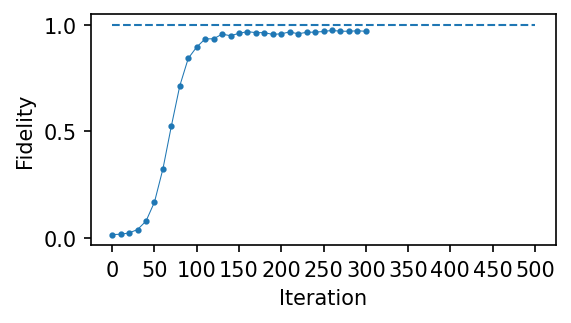

In [30]:
fig = plt.figure(1,figsize=(4,2), dpi=150, facecolor='w', edgecolor='k')

plt.plot(fidelity,linewidth=0.5,marker='o',markersize=2)
plt.xlabel("Iteration",fontsize=10)
plt.ylabel("Fidelity",fontsize=10)
plt.yticks([0.0,0.5,1.0],fontsize=10)
plt.xticks([0,5,10,15,20,25,30,35,40,45,50],[0,50,100,150,200,250,300,350,400,450,500],fontsize=10)
plt.hlines(1.0,xmin=0,xmax = 50,linewidth=1.0,linestyle="--")

plt.show()